# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('/content/drive/My Drive/fer2013.csv')

#checking usage value
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

# Data Overview

In [ ]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
#Target labels count
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


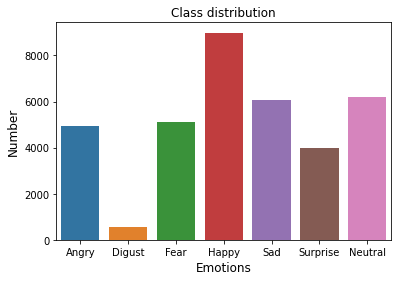

In [ ]:
#Plot Visualization
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [ ]:
# Splitting and reshaping pixels
face = data[data['emotion'] == 0].iloc[0]
print(face)

emotion                                                    0
pixels     70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Usage                                               Training
Name: 0, dtype: object


In [ ]:
img=np.array(face['pixels'].split())
print(img)

['70' '80' '82' ... '106' '109' '82']


In [ ]:
width, height = 48, 48
img.reshape(width, height)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

# Preprocessing

In [ ]:
# Splitting dataset into training, validation and test sets
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {} \nvalidation shape: {} \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3) 
validation shape: (3589, 3) 
test shape: (3589, 3)


In [ ]:
# Only one test set is required hence adding data_val to data_train
data_train = pd.concat([data_train, data_val])
data_train.shape

(32298, 3)

In [ ]:
# Convert pixel data from string to integers
data_train['pixels'] = data_train['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
data_test['pixels'] = data_test['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])

# Normalizing pixel data
train_X = np.array(data_train['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
test_X = np.array(data_test['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
print("train data :",train_X.shape)
print("test data  :",test_X.shape)

train data : (32298, 48, 48, 1)
test data  : (3589, 48, 48, 1)


In [ ]:
from keras.utils import to_categorical

# One Hot encoding the labels
num_classes = 7
train_Y = to_categorical(data_train['emotion'], num_classes)  
test_Y = to_categorical(data_test['emotion'], num_classes)
#train_Y
print("train data :",train_Y.shape)
print("test data  :",test_Y.shape)

train data : (32298, 7)
test data  : (3589, 7)


# Building CNN model

In [ ]:
# Importing required pacakages
#from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.optimizers import Adam
#from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
#import seaborn as sns

#import os
#import warnings
#warnings.filterwarnings("ignore")

In [ ]:
#Initializing Parameters (num_classes, width and height are already initialized)
epochs = 30
batch_size = 64
features = 64

In [ ]:
# CNN model

model = Sequential()

# module 1
model.add(Conv2D(2*2*features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 2
model.add(Conv2D(2*features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 3
model.add(Conv2D(features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten
model.add(Flatten())

# dense 1
model.add(Dense(2*2*2*features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# dense 2
model.add(Dense(2*2*features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# dense 3
model.add(Dense(2*features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output layer
model.add(Dense(num_classes, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0

# Data Augmentation

In [ ]:
# Generating data

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

train_aug = data_generator.flow(train_X, train_Y, batch_size)
test_aug =  data_generator.flow(test_X, test_Y,batch_size)

# Train Model

In [ ]:
# Train model
history = model.fit(train_aug,
      steps_per_epoch = len(train_X) / batch_size,  # 2000 images = batch_size * steps
      epochs = epochs,
      validation_data = test_aug,
      verbose = 1)

Epoch 1/30
505/504 [==============================] - 65s 129ms/step - loss: 1.6916 - accuracy: 0.3241 - val_loss: 1.9006 - val_accuracy: 0.3073
Epoch 2/30
505/504 [==============================] - 63s 126ms/step - loss: 1.4033 - accuracy: 0.4564 - val_loss: 1.3964 - val_accuracy: 0.4570
Epoch 3/30
505/504 [==============================] - 64s 126ms/step - loss: 1.2525 - accuracy: 0.5187 - val_loss: 1.3721 - val_accuracy: 0.4812
Epoch 4/30
505/504 [==============================] - 64s 126ms/step - loss: 1.1750 - accuracy: 0.5520 - val_loss: 1.2129 - val_accuracy: 0.5364
Epoch 5/30
505/504 [==============================] - 64s 126ms/step - loss: 1.1216 - accuracy: 0.5735 - val_loss: 1.2377 - val_accuracy: 0.5272
Epoch 6/30
505/504 [==============================] - 64s 126ms/step - loss: 1.0790 - accuracy: 0.5901 - val_loss: 1.1366 - val_accuracy: 0.5539
Epoch 7/30
505/504 [==============================] - 64s 126ms/step - loss: 1.0474 - accuracy: 0.6047 - val_loss: 1.1785 - val_ac

In [ ]:
# Evaluating model
train_score = model.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.7036926746368408
Train accuracy: 73.4782338142395
Test loss: 1.0151917934417725
Test accuracy: 65.50571322441101


In [ ]:
# Saving the model
model.save("model.h5")

#Visualize Training Performance

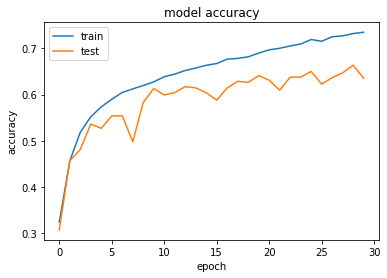

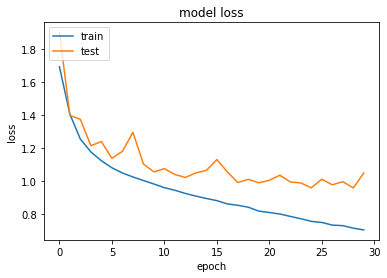

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Confusion Matrix.
pred_list = []; actual_list = []
predictions = model.predict(test_X)
for i in predictions:
  pred_list.append(np.argmax(i))
for i in test_Y:
    actual_list.append(np.argmax(i))
confusion_matrix(actual_list, pred_list)

array([[281,   4,  31,  11,  50,  11, 103],
       [ 17,  29,   1,   2,   3,   1,   2],
       [ 68,   2, 181,  19, 102,  42, 114],
       [ 14,   0,   9, 769,  11,  12,  64],
       [ 41,   1,  28,  28, 292,   6, 198],
       [ 12,   1,  47,  25,  10, 294,  27],
       [ 10,   2,  12,  24,  69,   4, 505]])

# Testing Captured Images

In [ ]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:
# This code captures an image on colab

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.99):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

In [ ]:
# This code crops the face from photo.jpg and saves it as capture.jpg

#Face crop algorithm
import cv2
from google.colab.patches import cv2_imshow

def facecrop(image):  
    facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)
    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
            sub_face = img[y:y+h, x:x+w]
            cv2.imwrite('Capture.jpg', sub_face)

    except Exception as e:
        print (e)

    cv2_imshow(img)

if __name__ == '__main__':
    facecrop('photo.jpg')

In [ ]:
#Testing the 'Capture' file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = 'Capture.jpg'
true_image = image.load_img(file)
img = image.load_img(file,color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()